# Introduction

An understanding of a system of interactions does not exist in one dimension in the way that a single point does, or even in two dimensions in the way a photograph represents depth by means of capturing light.  It exists in a more complex system of interactions across subsystems, relationships between entities, and messaging of various levels of importance through these relationships.  These depths of understandings happen based on the attributes and metadata encapsulated by each nodes, along with the relationships between them.  There are some common network structures framed in the context of graph-based associations such as social networks;  One less immediately apparent network is one of content understanding through entities that comprise associations through knowledge.  </br>
</br>
The following pipeline is built as an initial exploration on the processes involved in using AI modeling to build content associations between text entities.  It starts by consuming a dataset of text with labels, and transforms this through ML modeling into a graph which expresses multiple levels of text understanding.  One that can be connected to overarching structures of content as well as substructures of topics.  The utility of the final phase of the pipeline will be to use this graph to generate content-based predictions on new text entities or categorization predictions on topic clusters.  At this point a Graph Neural Network will leverage the relationships defined by topic modeling from text embeddings for these predictions. </br>
</br>
Topic modeling has been explored in a basic sense in previous systems, where cosine similarity and clustering have been explored to predict basic connections between text based data.  This pipeline leverages these building blocks to generate a more complex graph of associations via node attributes along with edges, which can hopefully generate more robust multi-dimensional predictions using the graph neural network. </br>
</br>
The pipeline for GNN evaluation is an initial step to allow further experimentation on approaches for defining and leveraging text to text entity knowledge to understand deeper topics and topic groupings within the data.  Since this pipeline merely begins the exploration possible using only text nodes and text relationships, added constructures to explore further once GNN evaluation is fine-tuned will be the addition of time-based attributes, cluster nodes, knowledge-graph category enrichments, and cross topic relationships.  By defining in more granular details the attributes and relational definitions that are possible, it will be possible to generate unsupervised context understanding via basic datasets of text entities. </br>
</br>

# Pipeline Generation of Content Depth for GNN Analysis

This pipeline uses a dataset with text and category columns to generate node and edge entities which will be used for building a Graph Neural Network.  </br>
</br>
Node entities are enhanced with attitional attributes by modeling each text embedding using Latent Dirichlet Allocation (LDA) and automated categorization through KMeans Clustering.  </br>
</br>
Edge relationships are defined between text entities using text embedding cosine similarities, along with entity assessment across nodes. </br>
</br>
The formulation of this pipeline is the foundation of an approach which will ultimately be used for training a TF-GNN and making predictions.  Predictions which will be possible include finding text entities with similar topics from a text entity unknown to the graph; Predicting topic similarity across a set of text entities; And understanding the clusters of associated topics that are present across a set of text entities.  The graph at it's baseline will be able to use the text to text relationships for understanding multidimensional associations of clusters, sub-topics, and content similarity based on simple prediction from text data or edge data, defined by text to text relationship attributes.

In [1]:
!pip install tensorflow_gnn gwpy &> /dev/null

In [2]:
!pip install flair gwpy &> /dev/null

In [3]:
!pip install basemap gwpy &> /dev/null

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
import tensorflow_gnn as tfgnn
import urllib.request
import matplotlib.pyplot as plt
import io
import zipfile
import sys
import datasets as ds
import tensorflow as tf
import re
import gensim
import nltk
import gensim.corpora as corpora
nltk.download('stopwords')
import nltk

from difflib import SequenceMatcher
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from math import sqrt, pow, exp
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from flair.embeddings import BertEmbeddings
from flair.data import Sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:

"""
  Contains Netsted Classes:

  DocumentTopicGenerator: Generates topics from each text sample using 
  Linear Discriminant Analysis (LDA) via a Gensim LDA Multicore Model
  Exposes the update_df method to add Topics to the dataframe from the 'text'
  column.

  KMeansClusterGenerator: Generates clusters from the text.
  -- The num_clusters parameter will set the number of clusters to generate.

  DataPreProcessor: Preprocesses the data
  -- Builds the node dataframe which contains:
    -- node name
    -- each of it's attributes
      -- topics
      -- embeddings
  -- Builds the edge dataframe which contains:
    -- node source
    -- node target
    -- each edge type
      -- cosine similarity
      -- share state of attributes

  DataFrameAdaptor: Adapting Data For the Graph.
  -- Defines nodes by index
  -- Updates graph edge node references to point to ids by index
  -- Generates training and test sets
  -- Generates a full adjacency matrix for testing

  TFGraph: Builds the graph structure and deep learning layers
  -- Builds the graph structure using tensors
  -- Builds the deep learning layers using Keras

  TFGNN: Exposes API methods to work with the model:
  -- get_model
  -- compile
  -- fit (train)
  -- predict

  PipelineValidation: Exposes API methods for validation:
  -- validate_clustering: Validates clusters against category labels using the 
      edges to see if the categorization is shared between nodes.  Returns the 
      accuracy of whether the category and cluster are both shared between 
      nodes.
  -- validate_topic_clusters: Validates primary topic cluster embeddings to see 
      how their dimensions deviate from the centroid of the cluster and the 
      neighboring clusters.  This gives context for whether key topics in a 
      cluster align with other topics in the same dimensional space.

  
  @param training_data_df: pandas dataframe
  @param training_data_df: pandas dataframe
  @param is_node_prediction: boolean
  @return: node dataframe, edge dataframe
"""
class CategoryAwareTFGNN():
  def __init__(self, training_data_df, labels, is_node_prediction=True):
    self.bert_embedding = BertEmbeddings()
    data_df = training_data_df
    data_df['text_preprocessed'] = self._clean_text(data_df['text'])
    data_df['embedding'] = [self._tokenize(token) for token in data_df['text_preprocessed']]
    data_df = self._DocumentTopicGenerator(data_df=data_df)._update_df()
    data_df['kmeans_gen_cluster'] = self._KMeansClusterGenerator(self, data_df=data_df)._generate()
    self.data_df = data_df
    index_by_topic, topic_by_index = self._get_index_topic_maps()
    self.index_by_topic = index_by_topic
    self.topic_by_index = topic_by_index

    self.df_category_labels = labels

    # Preprocess data into nodes and edges
    dataPreProcessor = self._DataPreProcessor(outer_self=self)
    dataPreProcessor._process()

    # Adapt dataframes for graph
    self.node_df = dataPreProcessor.nodes
    self.edge_df = dataPreProcessor.edges
    self.dataFrameAdaptor = self._DataFrameAdaptor(outer_self=self)

    # Build TF-Graph
    self.tfGraph = self._TFGraph(outer_self=self)
    
    # Set up datasets.  Edge predictions can be requested by @param is_node_prediction
    training_dataset = self.tfGraph.train_node_dataset
    validation_dataset = self.tfGraph.full_node_dataset
    prediction_dataset = self.tfGraph.full_node_dataset
    if not is_node_prediction:
      training_dataset = self.tfGraph.train_edge_dataset
      validation_dataset = self.tfGraph.full_edge_dataset
      prediction_dataset = self.tfGraph.full_edge_dataset

    # Build the graph tensors and keras layers
    self.tfGNN = self._TFGNN(outer_self=self, num_graph_updates=3, training_dataset=training_dataset, validation_dataset=validation_dataset, prediction_dataset=prediction_dataset)

    """
      Compiles, trains, and generates predictions from the model.
      This can be called after instantiating the CategoryAwareTFGNN for the pipeline results.
      @return: predictions from the model generated by the pipeline
    """
  def process(self):
    self.tfGNN._compile()
    self.tfGNN._fit()
    return self.tfGNN._predict()

  def _clean_text(self, column):
      df_column_without_punctuation = column.map(lambda x: re.sub('[,\.!?]', '', x))
      return df_column_without_punctuation.map(lambda x: x.lower())

  def _tokenize(self, token):
    word = Sentence(token)
    self.bert_embedding.embed(word)
    return word[0].embedding.numpy()

  
  def _get_index_topic_maps(self):
    dataset_length = len(self.data_df.index)
    topics = self.data_df['text_topic_1'].values.tolist() + self.data_df['text_topic_2'].values.tolist() + self.data_df['text_topic_3'].values.tolist()
    topics = sum([[self.data_df['text_topic_1'][i], self.data_df['text_topic_2'][i], self.data_df['text_topic_3'][i]] for i in range(0, dataset_length)], [])
    index_by_topic = {}
    for indx, topic in enumerate(topics):
      if topic not in index_by_topic:
        index_by_topic[topic] = indx
    topic_by_index = {v:k for k, v in index_by_topic.items()}
    return index_by_topic, topic_by_index

  """
    @return: The % accuracy of whether the category and cluster are both
    shared between nodes.
  """
  def validate_clustering(self):
    return self._PipelineValidation(outer_self=self)._validate_clustering()

  """
    @return: A map with the average amount of topic embedding deviation from the
    centroid of each cluster for the embeddings from the requested cluster. 
    The requested cluster is marked by the key name 'cluster_self' instead of a 
    cluster number in the map.
  """
  def validate_topic_clusters(self, cluster=0):
    return self._PipelineValidation(outer_self=self, is_topic_cluster_validation=True)._validate_topic_clusters(cluster_requested=cluster)

  class _PipelineValidation():
    def __init__(self, outer_self, is_topic_cluster_validation=False):
      self.node_df = outer_self.node_df
      self.edge_df = outer_self.edge_df
      self.topic_by_index = outer_self.topic_by_index
      self.tokenize = outer_self._tokenize
      self.index_by_topic = outer_self.index_by_topic
      if is_topic_cluster_validation:
        self.embedding_by_token = {v: self.tokenize(self.topic_by_index[v]) for k, v in self.index_by_topic.items()}
        self.topic_embeddings_by_cluster = self._get_topic_embeddings_by_clusters()
        self.top_topic_embeddings_by_cluster = self._get_top_topic_embeddings_by_clusters()
        self.topic_embedding_mean_by_cluster = self._get_topic_embedding_mean_by_cluster()
    
    """
      Validates clusters against category labels using the edges to see
      if the categorization is shared between nodes.

      This validating assumes that a category is a dimensional space which can be
      have boundaries represented by the dimensions of text token embeddings.

      @return: The % accuracy of whether the category and cluster are both
      shared between nodes.
    """
    def _validate_clustering(self):
      cluster_consistent_with_catgory_count = len(self.edge_df[self.edge_df["shares_category"]==self.edge_df["shares_cluster"]])
      return cluster_consistent_with_catgory_count / len(self.edge_df)

    def _get_topic_embeddings_by_clusters(self):
      # map {cluster number: topic embeddings []}
      topic_embed_by_cluster = {}
      df = self.node_df.filter(items=['cluster', "text_topic_1_index", "text_topic_2_index", "text_topic_3_index"])
      for i, row in enumerate(df.itertuples(), 1):
        cluster = row.cluster
        topic_embeddings = [
            self.embedding_by_token[row.text_topic_1_index], 
            self.embedding_by_token[row.text_topic_2_index], 
            self.embedding_by_token[row.text_topic_3_index]]
        if cluster in topic_embed_by_cluster:
          topic_embed_by_cluster[cluster] = topic_embed_by_cluster[cluster] + topic_embeddings
        else:
          topic_embed_by_cluster[cluster] = topic_embeddings
      return topic_embed_by_cluster

    def _get_top_topic_embeddings_by_clusters(self):
      # map {cluster number: topic embeddings []}
      top_topic_embed_by_cluster = {}
      df = self.node_df.filter(items=['cluster', "text_topic_1_index", "text_topic_2_index", "text_topic_3_index"])
      for i, row in enumerate(df.itertuples(), 1):
        cluster = row.cluster
        topic_embedding = [self.embedding_by_token[row.text_topic_1_index]]
        if cluster in top_topic_embed_by_cluster:
          top_topic_embed_by_cluster[cluster] = top_topic_embed_by_cluster[cluster] + topic_embedding
        else:
          top_topic_embed_by_cluster[cluster] = topic_embedding
      return top_topic_embed_by_cluster

    def _get_topic_embedding_mean_by_cluster(self):
      # map {cluster number: topic embedding mean []}
      topic_embedding_mean_by_cluster = {}
      for cluster, embedding_list in self.topic_embeddings_by_cluster.items():
        topic_embedding_mean_by_cluster[cluster] = np.average(embedding_list, axis=0)
      return topic_embedding_mean_by_cluster

    """
      Validates topic cluster embeddings to see how their dimensions deviate from
      the centroid of the cluster and the neighboring clusters.  This gives
      context for whether it is a topic in a cluster with other topics in the
      same dimensional space.


      This validating assumes that a category is a dimensional space which can be
      have boundaries represented by the dimensions of text token embeddings.

      @param cluster_requested: The cluster embeddings that the result is in context of. 
      @return: The % accuracy of whether the category and cluster are both
      shared between nodes.
    """
    def _validate_topic_clusters(self, cluster_requested):
      # map {cluster number: topic embedding deviations from mean for that cluster []}
      topic_embed_deviation_from_mean_for_cluster = {}

      # cluster in context of validation.  topic 1 embeddings only
      cluster_embedding_list = self.top_topic_embeddings_by_cluster[cluster_requested]

      # loop over each cluster's topic embedding mean
      for cluster, embedding_list in self.topic_embedding_mean_by_cluster.items():
        embedding_mean_for_cluster = self.topic_embedding_mean_by_cluster[cluster]
        difference_curr = np.zeros(len(embedding_mean_for_cluster), dtype='float32')
        # loop over the requested cluster's topic embeddings
        for token_embedding in cluster_embedding_list:
          difference = np.absolute(np.subtract(token_embedding, embedding_mean_for_cluster))
          difference_curr = np.add(difference_curr, difference)

        # Get the average difference for each embedding and sum them up for this cluster
        map_key = cluster
        if cluster == cluster_requested:
          map_key = 'cluster_self'
        topic_embed_deviation_from_mean_for_cluster[map_key] = np.sum(np.divide(difference_curr, len(cluster_embedding_list)))
      return topic_embed_deviation_from_mean_for_cluster


  """
    Generates topics from each text sample using Linear Discriminant Analysis (LDA) 
    via a Gensim LDA Multicore Model
  """
  class _DocumentTopicGenerator():
    def __init__(self, data_df):
      self.stop_words = stopwords.words('english')
      self.stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
      self.data_df = data_df

    def _update_df(self):
      self.data_df['text_topics'] = [self._predict_topics_from_gensim_lda_model(text) for text in self.data_df['text_preprocessed']]
      split = pd.DataFrame(self.data_df['text_topics'].to_list(), columns = ['text_topic_1', 'text_topic_2', 'text_topic_3'])
      return self._clean_up_df(pd.merge(self.data_df,split,how='left',left_index=True,right_index=True))

    """
      Removes tokens which are too long or short
    """
    def _gensim_preprocess(self, sentences):
      for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def _remove_stopwords(self, texts):
        return [[word for word in simple_preprocess(str(doc)) 
                if word not in self.stop_words] for doc in texts]

    def _predict_topics_from_gensim_lda_model(self, text):
      data = [text]
      data_words = list(self._gensim_preprocess(data))
      data_words = self._remove_stopwords(data_words)
      id2word = corpora.Dictionary(data_words)
      texts = data_words
      corpus = [id2word.doc2bow(text) for text in texts]
      num_topics = 1
      lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=num_topics)
      # Collect the topics from the first set provided in the list of topics.
      # A number of these are similar for this kind of corpus which is merely a 
      # few sentences.
      topics = list(map(lambda tup: tup[1], lda_model.top_topics(corpus)[0][0]))
      # Just get the top 3 of the topics for now. It would be worth investigating
      # the effectiveness of adding additional topics.
      return topics[:3]

    def _clean_up_df(self, updated_pd):
      # Clean up the dataframe by imputing null values and removing columns that have been replaced
      topic_names = ['text_topic_1', 'text_topic_2', 'text_topic_3']
      for topic in topic_names:
        updated_pd[topic] = [n if n is not None else "" for n in updated_pd[topic]]
      used_columns = ['text_topics', 'text']
      for used_column in used_columns:
        updated_pd.drop([used_column], axis=1, inplace=True)
      return updated_pd

  """
    Uses KMeans to generate clusters from the text entities
  """
  class _KMeansClusterGenerator():
    def __init__(self, outer_self, data_df, num_clusters=4):
      self.num_clusters = num_clusters
      self.data_df = data_df
    
    def _generate(self):
      return self._find_clusters()

    def _find_clusters(self):
      text_token_segments = [text_preprocessed for text_preprocessed in self.data_df['embedding']]
      kclusterer = KMeansClusterer(self.num_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
      return kclusterer.cluster(text_token_segments, assign_clusters=True)


  """
    Manages the preprocessing to collect and generate nodes and edges
  """
  class _DataPreProcessor():
    def __init__(self, outer_self):

      self.data_df = outer_self.data_df
      self.labels = outer_self.df_category_labels
      self.df_category_labels = outer_self.df_category_labels
      self.index_by_topic_map = outer_self.index_by_topic
    
    def _process(self):
      nodes, edges = self._process_training_data_to_graph_entities()
      self.nodes = nodes
      self.edges = edges

    """
      Builds the node and edge dataframes from the data.
      The node dataframe:
        -- node name
        -- each of it's attributes
          -- topics
      The edge dataframe:
        -- node source
        -- node target
        -- each edge type
      @return: node dataframe, edge dataframe
    """
    def _process_training_data_to_graph_entities(self):
      # Set up matrix variables
      node_cols = ["text_name", "category_num", 'cluster', "text_topic_1_index", "text_topic_2_index", "text_topic_3_index"]
      # category_node_cols = ["category_name", "category_num"]
      graph_df_nodes = pd.DataFrame(columns=node_cols)
      edge_cols = ["source","target", "shares_category", "shares_cluster", "cos_sim_target_with_source"]
      graph_df_edges = pd.DataFrame(columns=edge_cols)
      text_index = 0
      
      for text_index_i in range(0, len(self.data_df)):

        text_embedding_i = self.data_df['embedding'][text_index_i]

        category_name_i = self.labels[self.data_df['label'][text_index_i]]
        text_category_i = self.df_category_labels[self.data_df['label'][text_index_i]]
        label_i = self.data_df['label'][text_index_i]
        cluster_i = self.data_df['kmeans_gen_cluster'][text_index_i]

        graph_df_nodes.loc[len(graph_df_nodes.index)] = [
            # text name
            "text-" + str(text_index_i),
            # category num
            self.data_df['label'][text_index_i].astype(np.int32),
            # cluster
            cluster_i.astype(np.int32),
            # text topic 1 index
            np.int32(self.index_by_topic_map[self.data_df['text_topic_1'][text_index_i]]),
            # text topic 2 index
            np.int32(self.index_by_topic_map[self.data_df['text_topic_2'][text_index_i]]),
            # text topic 3 index
            np.int32(self.index_by_topic_map[self.data_df['text_topic_3'][text_index_i]])
        ]
        for text_index_j in range(0, len(self.data_df)):
          text_embedding_j = self.data_df['embedding'][text_index_j]

          text_category_j = self.df_category_labels[self.data_df['label'][text_index_j]]
          label_j = self.data_df['label'][text_index_j]
          cluster_j = self.data_df['kmeans_gen_cluster'][text_index_j]

          shares_category_binary = 0
          if label_i == label_j:
            shares_category_binary = 1
          
          shares_cluster_binary = 0
          if cluster_i == cluster_j:
            shares_cluster_binary = 1

          graph_df_edges.loc[len(graph_df_edges.index)] = [
            # source
            "text-" + str(text_index_i),
            # target
            "text-" + str(text_index_j),
            # shares category
            np.int32(shares_category_binary),
            # shares_cluster
            np.int32(shares_cluster_binary),
            # cos_sim_target_with_source,
            self._cos_similarity(text_embedding_i, text_embedding_j)
        ]
      return graph_df_nodes, graph_df_edges

    def _squared_sum(self, x):
      return round(sqrt(sum([a*a for a in x])),3)

    def _cos_similarity(self, x,y):
      return round(sum(a*b for a,b in zip(x,y))/float(self._squared_sum(x)*self._squared_sum(y)),3)

  """
    Manages the dataframe mutations needed for the GNN
  """
  class _DataFrameAdaptor():
    def __init__(self, outer_self):

      self.node_df = outer_self.node_df
      self.edge_df = outer_self.edge_df

      node_train, node_test = self._get_node_train_test_split()
      self.node_train = node_train
      self.node_test = node_test

      edge_train, edge_test = self._get_edge_train_test_split()
      self.edge_train = edge_train
      self.edge_test = edge_test

      node_full_adj, edge_full_adj = self._create_adj_id(self.node_df, self._generate_bidirectional_matrices(self.edge_df))
      self.node_full_adj = node_full_adj
      self.edge_full_adj = edge_full_adj

      node_train_adj, edge_train_adj = self._create_adj_id(self.node_train, self._generate_bidirectional_matrices(self.edge_train))
      self.edge_train_adj = edge_train_adj
      self.node_train_adj = node_train_adj

    def _get_node_train_test_split(self):
      return train_test_split(self.node_df,test_size=0.15,random_state=42)

    def _get_edge_train_test_split(self):
      edge_train = self.edge_df.loc[~((self.edge_df['source'].isin(self.node_test.index)) | (self.edge_df['target'].isin(self.node_test.index)))]
      edge_test = self.edge_df.loc[(self.edge_df['source'].isin(self.node_test.index)) | (self.edge_df['target'].isin(self.node_test.index))]
      return edge_train, edge_test
    
    def _generate_bidirectional_matrices(self, directional_df):
      reverse_df = directional_df.rename(columns={'source':'target','target':'source'})
      reverse_df = reverse_df[directional_df.columns]
      reverse_df = pd.concat([directional_df, reverse_df], ignore_index=True, axis=0)
      return reverse_df

    def _create_adj_id(self, node_df, edge_df):
      node_df = node_df.reset_index()
      edge_df = pd.merge(edge_df,node_df[['text_name','index']].rename(columns={"index":"source_id"}),
                        how='left',left_on='source',right_on='text_name').drop(columns=['text_name'])
      edge_df = pd.merge(edge_df,node_df[['text_name','index']].rename(columns={"index":"target_id"}),
                        how='left',left_on='target',right_on='text_name').drop(columns=['text_name'])
      
      edge_df.dropna(inplace=True)
      edge_df = edge_df.astype({col: 'int32' for col in edge_df.select_dtypes('int64').columns})
      return node_df, edge_df

  """
    Builds the graph structure for the GNN from the node and edge dataframes using tfgnn.GraphTensor, tfgnn.NodeSet, and tfgnn.EdgeSet.
    Builds the deep learning layers for the GNN using Keras and makes these available for fitting the TF-GNN model
  """
  class _TFGraph():
    def __init__(self, outer_self):
      full_tensor = self._create_graph_tensor(outer_self.dataFrameAdaptor.node_full_adj, outer_self.dataFrameAdaptor.edge_full_adj)
      train_tensor = self._create_graph_tensor(outer_self.dataFrameAdaptor.node_train_adj, outer_self.dataFrameAdaptor.edge_train_adj)

      self.full_node_dataset = self._generate_dataset_from_graph(full_tensor, self._node_batch_merge)
      self.train_node_dataset = self._generate_dataset_from_graph(train_tensor, self._node_batch_merge)

      self.full_edge_dataset = self._generate_dataset_from_graph(full_tensor, self._edge_batch_merge)
      self.train_edge_dataset = self._generate_dataset_from_graph(train_tensor, self._edge_batch_merge)

      self.set_initial_node_state = self._set_initial_node_state
      self.set_initial_edge_state = self._set_initial_edge_state

      graph_spec = self.train_edge_dataset.element_spec[0]
      self.input_graph = tf.keras.layers.Input(type_spec=graph_spec)
      print("graph spec compatibility: ", graph_spec.is_compatible_with(full_tensor))

      self.dense_layer = self._dense_layer

    def _create_graph_tensor(self, node_df, edge_df):
      graph_tensor = tfgnn.GraphTensor.from_pieces(
        node_sets = {
            "articles": tfgnn.NodeSet.from_fields(
                sizes = [len(node_df)],
                features ={
                    'article_category': np.array(node_df['category_num'], dtype='int32').reshape(len(node_df),1),
                    'article_cluster': np.array(node_df['cluster'], dtype='int32').reshape(len(node_df),1),
                    'article_topic_1_id': np.array(node_df['text_topic_1_index'], dtype='int32').reshape(len(node_df),1),
                    'article_topic_2_id': np.array(node_df['text_topic_2_index'], dtype='int32').reshape(len(node_df),1),
                    'article_topic_3_id': np.array(node_df['text_topic_3_index'], dtype='int32').reshape(len(node_df),1)
                })
            },
        edge_sets ={
            "topics": tfgnn.EdgeSet.from_fields(
                sizes = [len(edge_df)],
                features = {
                    'topics_shared': np.array(edge_df['shares_category'],
                                          dtype='int32').reshape(len(edge_df),1),
                    'cosine_similarity': np.array(edge_df['cos_sim_target_with_source'], dtype='float32').reshape(len(edge_df),1)},
                adjacency = tfgnn.Adjacency.from_indices(
                    source = ("articles", np.array(edge_df['source_id'], dtype='int32')),
                    target = ("articles", np.array(edge_df['target_id'], dtype='int32'))))
        }
      )
      return graph_tensor

    def _node_batch_merge(self, graph):
      graph = graph.merge_batch_to_components()
      node_features = graph.node_sets['articles'].get_features_dict()
      edge_features = graph.edge_sets['topics'].get_features_dict()
      
      label = node_features.pop('article_category')
      _ = edge_features.pop('topics_shared')
      
      new_graph = graph.replace_features(
          node_sets={'articles':node_features},
          edge_sets={'topics':edge_features})
      return new_graph, label

    def _edge_batch_merge(self, graph):
      graph = graph.merge_batch_to_components()
      node_features = graph.node_sets['articles'].get_features_dict()
      edge_features = graph.edge_sets['topics'].get_features_dict()
      
      _ = node_features.pop('article_category')
      label = edge_features.pop('topics_shared')
      
      new_graph = graph.replace_features(
          node_sets={'articles':node_features},
          edge_sets={'topics':edge_features})
      return new_graph, label

    def _generate_dataset_from_graph(self, graph, function):
      dataset = tf.data.Dataset.from_tensors(graph)
      dataset = dataset.batch(32)
      return dataset.map(function)

    def _set_initial_node_state(self, node_set, node_set_name):
      features = [
          tf.keras.layers.Dense(32,activation="relu")(node_set['article_cluster']),
          tf.keras.layers.Dense(32,activation="relu")(node_set['article_topic_1_id']),
          tf.keras.layers.Dense(32,activation="relu")(node_set['article_topic_2_id']),
          tf.keras.layers.Dense(32,activation="relu")(node_set['article_topic_3_id'])
      ]
      return tf.keras.layers.Concatenate()(features)

    def _set_initial_edge_state(self, edge_set, edge_set_name):
      features = [
          tf.keras.layers.Dense(32,activation="relu")(edge_set['cosine_similarity'])
      ]
      return tf.keras.layers.Concatenate()(features)
    
    def _dense_layer(self, units=64, l2_reg=0.1, dropout=0.25, activation='relu'):
      regularizer = tf.keras.regularizers.l2(l2_reg)
      return tf.keras.Sequential([
          tf.keras.layers.Dense(units,
                                kernel_regularizer=regularizer,
                                bias_regularizer=regularizer),
          tf.keras.layers.Dropout(dropout)])
        
  """
    Exposes API methods to:
    -- Build the model
    -- Compile the model
    -- Fit the model (training)
    -- Predicting from the model

    These methods need to be called in order.  However multiple predictions can be made on the same model.
  """
  class _TFGNN():
    def __init__(self, outer_self, num_graph_updates, training_dataset, validation_dataset, prediction_dataset, steps=10, epochs=100, loss=None, metrics=None):
      # Graph update variables
      self.input_graph = outer_self.tfGraph.input_graph
      self.dense_layer = outer_self.tfGraph.dense_layer
      self.set_initial_node_state = outer_self.tfGraph.set_initial_node_state
      self.set_initial_edge_state = outer_self.tfGraph.set_initial_edge_state


      self.num_graph_updates = num_graph_updates
      self.model = self._get_model()
      
      self.training_dataset = training_dataset
      self.validation_dataset = validation_dataset
      self.prediction_dataset = prediction_dataset

      # Training params
      self.steps_per_epoch = steps
      self.epochs = epochs

    def _get_model(self):
      graph = tfgnn.keras.layers.MapFeatures(
          node_sets_fn=self.set_initial_node_state,
          edge_sets_fn=self.set_initial_edge_state
          )(self.input_graph)

      graph_updates = self.num_graph_updates
      for i in range(graph_updates):
          graph = tfgnn.keras.layers.GraphUpdate(
              node_sets = {
                  'articles': tfgnn.keras.layers.NodeSetUpdate({
                      'topics': tfgnn.keras.layers.SimpleConv(
                          message_fn = self.dense_layer(32),
                          reduce_type="sum",
                          sender_edge_feature = tfgnn.HIDDEN_STATE,
                          receiver_tag=tfgnn.TARGET)},
                      tfgnn.keras.layers.NextStateFromConcat(
                          self.dense_layer(64)))})(graph) #start here
          
          logits = tf.keras.layers.Dense(1,activation='softmax')(graph.node_sets["articles"][tfgnn.HIDDEN_STATE])
      return tf.keras.Model(self.input_graph, logits)

    def _compile(self):
      self.model.compile(
          tf.keras.optimizers.Adam(learning_rate=0.3),
          # loss = 'categorical_crossentropy',
          # metrics = ['categorical_accuracy']
      )

    def _fit(self):
      es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=100,restore_best_weights=True)
      self.model.fit(self.training_dataset.repeat(),
            validation_data=self.validation_dataset,
            steps_per_epoch=self.steps_per_epoch,
            epochs=self.epochs,
            callbacks=[es])
      
    def _predict(self):
      return self.model.predict(self.prediction_dataset)

In [6]:
"""
  Loads training data.
  Shuffles the training data.
  Takes a slice of the training data up to the side defined in data_set_size.
  This training set size can be reduced for pipeline experiments.

  @param data_set_size: number
  @return: dataframe, label array
"""
def collect_training_data(data_set_size):
    ag_news_ds = ds.load_dataset('ag_news', save_infos=True)
    ag_news_ds_train = ag_news_ds['train']
    ag_news_ds_train_df = pd.DataFrame(data=ag_news_ds_train)
    ag_news_ds_train_df_shuffled = ag_news_ds_train_df.sample(frac = 1).reset_index(drop=True)
    ag_news_ds_train_df_shuffled = ag_news_ds_train_df_shuffled[:data_set_size]
    labels = ag_news_ds['test'].features['label'].names
    return ag_news_ds_train_df_shuffled, labels

In [7]:
training_data_df, labels = collect_training_data(20)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
training_data_df.head()

,text,label
0,Wal-Mart's successis market-driven The liberal...,2
1,"Business ; SBC May Cut More Than 10,000 Jobs L...",2
2,Hatch #39;s bill for tuition breaks for undocu...,3
3,Apple computer unveils mini-stores Capitalizin...,3
4,AOL Fraud Claim Settled Time Warner will be pa...,2


In [9]:
ca_TFGNN = CategoryAwareTFGNN(training_data_df=training_data_df, labels=labels)

<ipython-input-5-429a9c797c9c>:59: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  self.bert_embedding = BertEmbeddings()
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initiali

graph spec compatibility:  False


# Pipeline Context:

The TensorFlow-GNN is a library that Google has released in the alpha stage, recently.  The first tutorial on it using an external dataset appeared in the last few months, and tutorials using the internal datasets for the library have been presented at neural network conferences as recently as late last year.  This initial phase of the library requires very specific configuration, structures, shapes, and formats for it to run successfully.  Because the specific error reporting is minimal, a number of challenges exist in debugging, leading any engineer that dares to venture into these waters at the mercy of some trial and error.  The interesting part of it the learning process in understanding in greater depth about how the processes of Graph Neural networks are set up, and the detail involved in abstracting the graph building itself from a basic dataset.  Since this process offers the most flexibility for experimentation and future research.  An example demonstrating the flexability available from determining one's own graph structures for experimentation via the tensors available is as follows.  The first is an example of a graph tensor function which I used to build a singular node and edge type graph.  It is used in this experiment pipeline but a future expansion on it could easily be engineered to include multiple types of both nodes and edges as depicted in the following structure.  A comparison of configurations shows the level of detail and range of possibilities that could be additionally possible given some further adaptations.  I find it most effective to start new processes with the most basic structures and therefore this pipeline evaluates a graph with a singular type of node and edge type, each with varying levels of feature metadata associated with them.  Once the model is trainable using a loss function for categorical_crossentropy, and hyperparameters are tunable, it will be a good time to begin to explore the variations of using added nodes, edge types, and metadata which includes a temporal aspect.

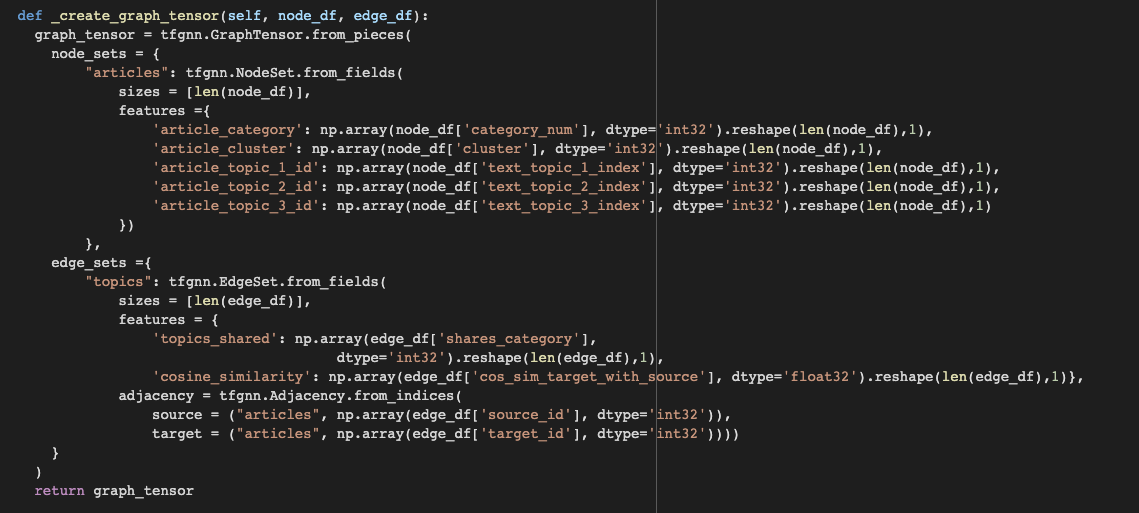

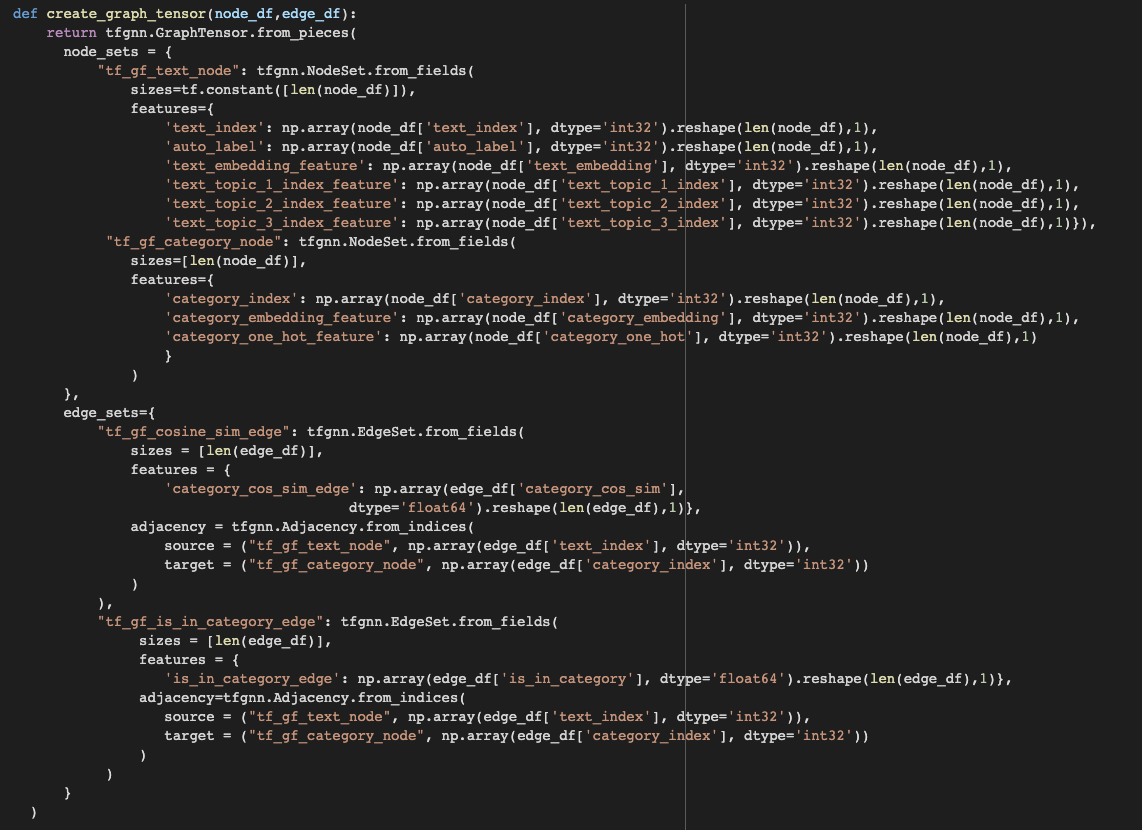

# Analysis And Observations
Initial observations are as follows on the graph structure dataframes that were built using an LDM model and KMeans Clustering model as part of the pipeline is a key first step.  </br>
</br>
The dataframes themselves generated by the pipeline connect to one another through the edge dataframe, which expresses the attribute-based relationships between the nodes.  The key edge relationships collected via ML processes in the pipeline are the attributes for 'shares cluster' and 'cos_sim_target_with_source'.  'shares cluster' is used to express whether the text nodes have the same cluster generated from KMeans clustering, and the 'cos_sim_target_with_source' is measured from the angle of difference between each source and target text node, expressing a measure of similarity between nodes.

## Generated Node Dataset

In [10]:
ca_TFGNN.node_df

,text_name,category_num,cluster,text_topic_1_index,text_topic_2_index,text_topic_3_index
0,text-0,2,1,0,1,2
1,text-1,2,2,3,4,5
2,text-2,3,1,6,7,1
3,text-3,3,3,9,10,11
4,text-4,2,3,12,13,14
5,text-5,2,1,15,16,17
6,text-6,1,0,18,1,20
7,text-7,0,0,21,22,23
8,text-8,0,2,24,25,26
9,text-9,2,2,27,28,29


## Generated Edge Dataset

In [11]:
ca_TFGNN.edge_df

,source,target,shares_category,shares_cluster,cos_sim_target_with_source
0,text-0,text-0,1,1,1.000
1,text-0,text-1,1,0,0.272
2,text-0,text-2,0,1,0.312
3,text-0,text-3,0,0,0.590
4,text-0,text-4,1,0,0.400
...,...,...,...,...,...
395,text-19,text-15,1,0,0.366
396,text-19,text-16,0,0,0.344
397,text-19,text-17,0,1,0.577
398,text-19,text-18,0,1,0.315


A Single edge entity between text nodes 0 and 12 expresses that they have the same category and have low similarity with one another

In [12]:
ca_TFGNN.edge_df.iloc[12]

source                         text-0
target                        text-12
shares_category                     0
shares_cluster                      0
cos_sim_target_with_source      0.209
Name: 12, dtype: object

## Graph Queries
One immediate result from the pipeline is a set of dataframes from which content understanding can be determined based on simple graph queries using clusters to understand topic groupings, and article similarity.  This doesn't leverage the deeper learning that could be found from a GNN in the context of network connections via message passing, however being able to ask questions of the data and find answers from the initial modeling in the pipeline provides a pipeline benchmark for comparisons in the future from full pipeline results once the GNN is modeling the graph correctly.

It is apparent that graph walks such as DFS and BFS, and queries can be done from this structure even before the GNN analysis to find:
1. All articles that connect to an article with a similarity score above a set threshold
2. Topics of all articles from #1.  
3. The number of items in each cluster
4. Key topics in each cluster

# Validation And Analysis
Validation methods have been built into the pipeline for the results of each of the ML processes at interim phases of the pipeline. </br>
</br>
## Clustering Validation
The first of these validates the clustering step using the category labels for each article in the dataset to provide an accuracy. </br>
</br>
The second valides the LDA topic generation in context with the clusters in the previous step.  It checks whether topic analysis within clusters generalizes by assessing first the average embedding value in each dimension for each cluster.  And secondarily by assessing the average deviation from the mean of the most probably token for each article for tokens in each cluster, compared to the average deviation from the mean for the tokens with other clusters.  The idea is to provide context on whether the top assigned topics are correctly categorized.  It is possible to do this same analysis using categories instead, however this validation is contextual to the previous step of the pipeline, so low differences in token dimension deviation within clusters but high differences in token dimension deviation across other clusters will give insights into how well the topics fall into the cluster spaces.

# KMeans Clustering Validation

The following metric shows that well over 65% of the time the KMeans clustering algorthm does unsupervised categorization which is in line with the labeled categories of the data. </br>
</br>
This validation method checks the frequency with which each pair of text entities has matching categories and matching clusters in context with each possible pair of text entities in the data set.  </br>
</br>
This is a good result since there were no clear boundaries defined by text embedding spaces in the dataset.  The ML model generalized these text embeddings into categories without being given labels to train on in a way that separated them similar to the approach a human labeler might take. </br>
</br>
Some improvements which might improve upon the accuracy of clustering would be improvements in pre-processing text for embedding.  One approach worth attempting would be to see if a set of topics generated from LDA modeling would be the better source for data for each text entitity instead of the less sucinct text used for each in this example.

In [13]:
ca_TFGNN.validate_clustering()

0.62

## Topic Modeling Validation

The following method from the pipeline validation module, 'validate_topic_clusters' validates topic cluster embeddings.  It basically looks to see if the primary topics for the cluster are closest to the mean embedding centroid of all topics in their current cluster or whether they may belong in one of the neighboring clusters using the dimension space of the tokenized word for the topic for each cluster.  This validation assumes that topics closest to the centroid for the cluster they are assigned to are most associated to that cluster.  It uses the clustering assignment in this way to check that the top topics returned by the LDA modeling are actually subtopics based on their respective embedding token dimensionality. </br>
 </br>
 The validation is built in such a way that we expect to see the value of 'cluster_self' with the lowest measure of average deviation from the centroid for each cluster.  This is in fact the case.  It doesn't validate that the topics are necessarily the best selections from each article, but in context of the content graph being generated it shows the trend that I was hoping to see, which is that on average the highest selected topics for each cluster are closest to that cluster's centroid. </br>
</br>
There is possibly some bias in this analysis because the mean of the centroid is collected using the key topic along with the secondary and teritiary topic for each article from the LDA analysis for the average.  But it is possible that the key topics
are more closely associated with the centroid of a neighboring cluster.  So it provides informative measurement that the centroids of each cluster are close to one another and generally shows that the key topics are not completely dispersed across all clusters.  The clusters were not as separate as I had expected them to be.  Perhaps this is because such a vast number of topics can be associated with a category, and that we have no initial context of what a category means.  Knowledge graph or LLM enrichment could be an interesting improvement, here. </br>
</br>
Determining a validation approach for the LDA analysis in the pipeline is a key measurement to the ultimate effectiveness of the building blocks of the pipeline.  A validation of the LDA modeling as a building block, itself could happen additionally via cross-fold validation where multiple samples are collected and the variance across them are measured.  This would be even more interesting on datasets where the text segments were vast, and the options for topics for the LDA were vast.

In [14]:
for i in range(0, 4):
  print(ca_TFGNN.validate_topic_clusters(i))

{1: 1024.4502, 2: 991.1519, 3: 1033.6565, 'cluster_self': 949.2789}
{'cluster_self': 1049.5054, 2: 1107.1298, 3: 1130.3966, 0: 1117.151}
{1: 1248.411, 'cluster_self': 1118.1104, 3: 1179.2318, 0: 1186.1232}
{1: 1124.7327, 2: 1040.7463, 'cluster_self': 919.75775, 0: 1069.4414}


## GNN Modeling Validation - Node and Edge Predictions

I spent hours working to set up the configuration for the GNN correctly, however I constantly ran into two issues. </br>
1. The schema defined for the graph needs to agree with the adapted scheme for training a subset of the data with a 'missing' piece of a graph.  For instance to train for predictions on nodes, the GNN needs to receive a training set without the label nodes and a training set with the label nodes, to learn to predict the specific nodes in the same way as any ML model would need to learn to predict labels.  These two schemas seem to need to agree, but a merge process occurs in message passing in the GNN in which nodes are dropped for analysis by the model.  The result was often a merging error in the training function if the schema wasn't always as expected, where all node features are present.  The same issue occurs with edges where the defined schema isn't always found in the merge process where training needs to occur for predictions to analyzed.  </br>
</br>
2.  Because I wasn't able to find answers to because of the very limited information on the issues with the schema configuration definition, a downstream issue in the pipeline surfaced when I set the loss function.  I wanted to be able to use 'categorical_crossentropy' as the loss since I wanted to predict the category node attribute which could be one of four numbers each signifying an article category.</br>
</br>

I was able to train the model without setting a defined loss function with poor results.  The results were erroneous, however, and not even close to what I was aiming for.  These results didn't change based on whether I was predicting for category nodes or the edge attribute for whether an article was in a certain category.  A prediction of about 1 was assigned to each item in the test set, no matter whether I selected a node or edge prediction. </br>
</br>
Because of these issues I went through my graph and setup multiple times.
I learned to construct my graph with more care than any neural network setup prior in regards to index references, data types, and shape configuration and analysis.  For graph neural networks there structure of the graph itself needs to be set up with attention to detail on assigning correctly the nodes, edges, and attributes along with the approach the message passing merge functions will take to update these details based on the type of edge or node.  This greatly differs from other neural network training processes where actually setting upt he network is the easiest part of the pipeline, becuase with these approaches one can just pass a simple pandas dataframe without a label, and slot a set of labels into the validation slot for training, then spend engineering time addressing adaptations with hyperparameters.  The dynamic variables to graph neural networks can be prone to errors, but also make them more intriguing and interesting since there are so many customizable factors in the definition and expression of the graph within the neural network.  I like working with the alpha library because it allows for work on the details of the neural network, however the bugs were frustrating.  </br>
</br>
To try to resolve the errors I was running into at the most simple level possible for debugging I started with the most simple pipeline possible.  This is included in this repository in a file name, "BASIC_GNN_for_testing.pynb". The error becomes apparent when one uncomments the code, "# loss = 'categorical_crossentropy',".  I have crawled over the pipeline numerous times looking for possible typos, mislabeled data types, and the like and have not yet found the bug.  Once I discover the solution to resolve this issue I plan to continue to work on my content-aware GNN pipeline.  I especially would like to increase the variation in node types, add time as an attribute to the article node, and generate more category context for the graph using knowledge graphs.  It might be interesting to explore an integration with LLMs to enhance the level of content detail at each level of the graph as well in future research.  I can imagine the combination of LLMs and GNNs being very powerful in the future, when they are paired together within a pipeline to connect to one another. </br>
</br>
Until additional progress can be made, the pipeline itself is tested via the following prediction results, although they do not yet express the capabilities of the GNN structure or the approaches used for building the graph, yet.  This is not an impass but a signal that there is more work that needs to be done to get to the point where the pipeline can run end to end as it should be.  My next steps will be in connecting with others who have existing experience with GNNS, such as the author of the blog who wrote the tutorial I used to build the GNN structure and the training and testing sets in this pipeline, Michael Malin, to see if he has any suggestions on resolving the bug.  At that point, however further adaptation to make the graph itself more comprehensive will be the next key step for further improvements.

In [15]:
# Get predictions through the compile, fit, predict API exposed from the pipeline.
predictions = ca_TFGNN.process()

Epoch 1/100


10/10 [==============================] - 2s 67ms/step - loss: 62.6343 - val_loss: 36.2774
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 16.5183 - val_loss: 11.1083
Epoch 3/100
10/10 [==============================] - 0s 18ms/step - loss: 6.2876 - val_loss: 2.6670
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 2.3233 - val_loss: 1.2595
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 0.8728 - val_loss: 0.3773
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 0.3077 - val_loss: 0.1779
Epoch 7/100
10/10 [==============================] - 0s 17ms/step - loss: 0.1154 - val_loss: 0.0587
Epoch 8/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0422 - val_loss: 0.0213
Epoch 9/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0153 - val_loss: 0.0083
Epoch 10/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 1

In [16]:
print(predictions)

[[0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [0.99999994]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


## Thoughts

Although the GNN isn't set up quite yet it has sparked my passion to continue to work on this pipeline until it is set up for effective results.  One nice opportunity given that the TF-GNN library is in alpha launch is to collaborate with the researchers who have built the library to provide feedback and information from this pipeline that serves as a prototype for further research.  I plan to continue to build the pipeline in an abstract way so that it can perform GNN modeling and predictions eventually on any dataset with text and category columns.  And so that a deeper understanding can be found on the ideal constructs to use to express content awareness through topic modeling, clustering, cosine similarities, and data enrichment.</br>
</br>

## References

Malin, Michael. "TensorFlow-GNN: An End-To-End Guide For Graph Neural Networks", Towards Data Science, 1/16/2023, https://towardsdatascience.com/tensorflow-gnn-an-end-to-end-guide-for-graph-neural-networks-a66bfd237c8c. </br>
</br>
TensorFlow Core. "Introducing TensorFlow Graph Neural Networks" TensorFlow Blog, 11/18/2023, https://blog.tensorflow.org/2021/11/introducing-tensorflow-gnn.html. </br>
</br>
Salama, Khalid. "Node Classification with Graph Neural Networks", Keras, 5/30/2021, https://keras.io/examples/graph/gnn_citations/. </br>
</br>
Kapadia, Shashank. "Topic Modeling in Python: Latent Dirichlet Allocation (LDA)", Towards Data Science, 4/14/2019, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0. </br>
</br>
Gensim Tutorials, "Corpora and Vector Spaces", 2016, https://tedboy.github.io/nlps/gensim_tutorial/tut1.html#from-strings-to-vectors. </br>
</br>
Sami Abu-el-Haija, Neslihan Bulut, Bryan Perozzi, and Anton Tsitsulin. "Tutorial: Graph Neural Networks in TensorFlow: A Practical Guide", Learning on Graphs (LOG) Conference 2022, https://logconference.org/schedule-tutorials/#graph-neural-networks-in-tensorflow-a-practical-guide, https://github.com/tensorflow/gnn/tree/main/examples/tutorials/log_2022 </br>
</br>
shristikotaiah. "FLAIR – A Framework for NLP", Geeks For Geeks, https://www.geeksforgeeks.org/flair-a-framework-for-nlp/. </br>
</br>
Malin, Michael. "Why You Should Always Use Feature Embeddings With Structured Datasets", Towards Data Science, 2/10/2021, https://towardsdatascience.com/why-you-should-always-use-feature-embeddings-with-structured-datasets-7f280b40e716. </br>
</br>
Abu-el-Haija, Sami, "Tutorial: Graph Neural Networks in TensorFlow: A Practical Guide", Youtube, 12/18/2022, https://www.youtube.com/watch?v=JqWROPYeqjA&ab_channel=LearningonGraphsConference.</br>
</br>